<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-configuration" data-toc-modified-id="Notebook-configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook configuration</a></span></li><li><span><a href="#Data-set-generation" data-toc-modified-id="Data-set-generation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data set generation</a></span></li><li><span><a href="#Common-nearest-neighbours-clustering-on-data-points-as-input" data-toc-modified-id="Common-nearest-neighbours-clustering-on-data-points-as-input-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Common-nearest-neighbours clustering on data points as input</a></span></li><li><span><a href="#Common-nearest-neighbours-clustering-with-pre-computed-distances" data-toc-modified-id="Common-nearest-neighbours-clustering-with-pre-computed-distances-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Common-nearest-neighbours clustering with pre-computed distances</a></span></li><li><span><a href="#Common-nearest-neighbours-clustering-with-pre-computed-neighbourhoods" data-toc-modified-id="Common-nearest-neighbours-clustering-with-pre-computed-neighbourhoods-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Common-nearest-neighbours clustering with pre-computed neighbourhoods</a></span></li><li><span><a href="#Common-nearest-neighbours-clustering-with-pre-computed-sorted-neighbourhoods" data-toc-modified-id="Common-nearest-neighbours-clustering-with-pre-computed-sorted-neighbourhoods-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Common-nearest-neighbours clustering with pre-computed sorted neighbourhoods</a></span></li></ul></div>

# Clustering of scikit-learn Toy data sets

In [1]:
import sys

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler

from cnnclustering import cluster
from cnnclustering import _types

The notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.8 (default, Mar 11 2021, 08:58:19) 
[GCC 8.3.0]


## Notebook configuration

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

## Data set generation

To see Common-nearest-neighbour clustering in action, let's have a look at a handful of basic 2D data sets from scikit-learn (like here in the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)).

In [5]:
# Data set generation parameters
np.random.seed(0)
n_samples = 2000

In [6]:
# Data set generation
# circles
noisy_circles, _ = datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05
    )

# moons
noisy_moons, _ = datasets.make_moons(
    n_samples=n_samples,
    noise=.05
    )

# blobs
blobs, _ = datasets.make_blobs(
    n_samples=n_samples,
    random_state=8
    )

# None
no_structure = np.random.rand(
    n_samples, 2
    )

# aniso
random_state = 170
X, y = datasets.make_blobs(
    n_samples=n_samples,
    random_state=random_state
    )

transformation = [[0.6, -0.6], [-0.4, 0.8]]
aniso = np.dot(X, transformation)

# varied
varied, _ = datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=random_state
    )

In [7]:
# Define cluster parameters
dsets = [ # "name", set, **parameters
    ('circles', noisy_circles, {
        'radius_cutoff': 0.5,
        'cnn_cutoff': 20,
        'member_cutoff': 100,
        'max_clusters': None
        }),
    ('moons', noisy_moons, {
        'radius_cutoff': 0.5,
        'cnn_cutoff': 20,
        'member_cutoff': 2,
        'max_clusters': None
        }),
    ('varied', varied, {
        'radius_cutoff': 0.28,
        'cnn_cutoff': 20,
        'member_cutoff': 20,
        'max_clusters': None
        }),
    ('aniso', aniso, {
        'radius_cutoff': 0.29,
        'cnn_cutoff': 30,
        'member_cutoff': 5,
        'max_clusters': None
         }),
    ('blobs', blobs, {
        'radius_cutoff': 0.4,
        'cnn_cutoff': 20,
        'member_cutoff': 2,
        'max_clusters': None
        }),
    ('None', no_structure, {
        'radius_cutoff': 0.5,
        'cnn_cutoff': 20,
        'member_cutoff': 1,
        'max_clusters': None
        }),
    ]

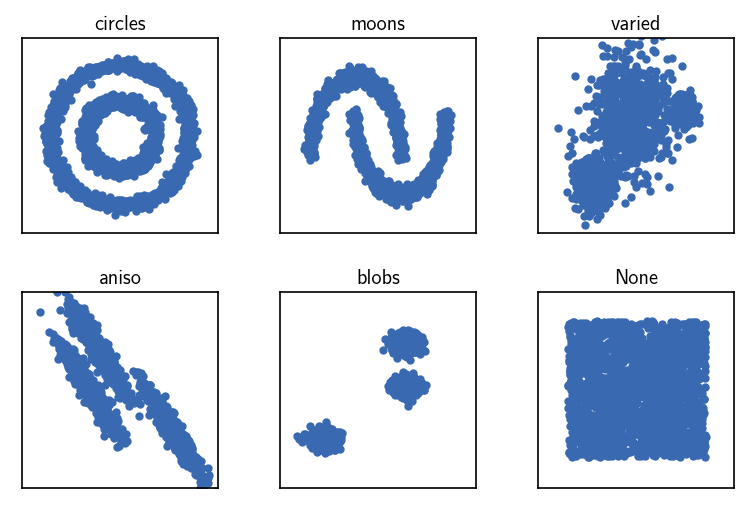

In [8]:
# Plot the original data sets
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, *_) in enumerate(dsets):
    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)
    # Plot
    Ax[count].plot(data[:, 0], data[:, 1], **line_props)
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )


## Common-nearest-neighbours clustering on data points as input

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.078
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.073
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

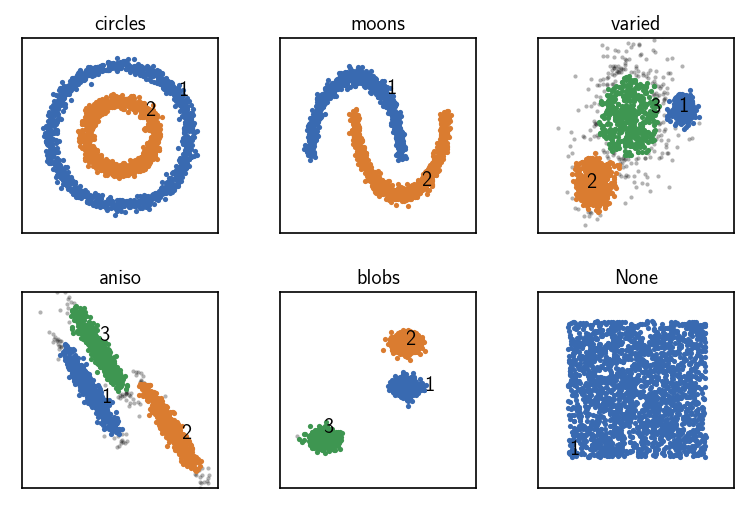

In [9]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)

    clustering = cluster.prepare_clustering(data)

    # Calculate neighbours brute force
    clustering.fit(**params)
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

## Common-nearest-neighbours clustering with pre-computed distances

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.028
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.030
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

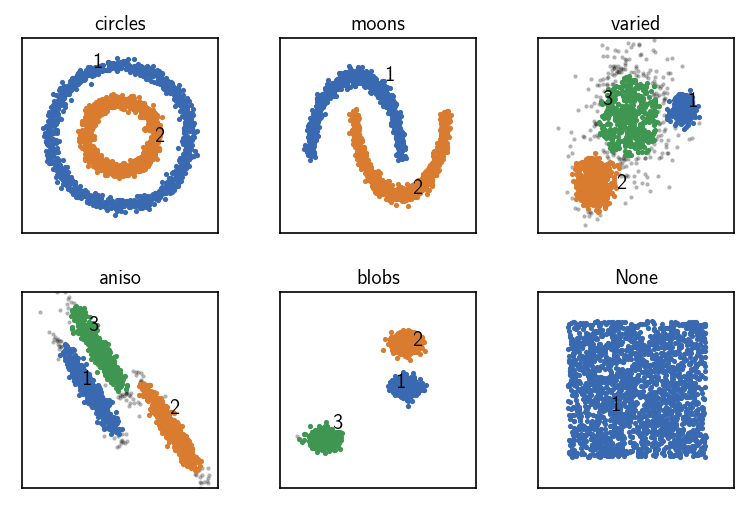

In [10]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    
    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)
    
    clustering = cluster.prepare_clustering(data)  
    
    # Pre-compute distances
    distances = pairwise_distances(data)
    clustering_dist = cluster.prepare_clustering(distances)
    clustering_dist._metric = _types.MetricExtPrecomputed()
    
    # Use pre-computed distances
    clustering_dist.fit(**params)
    clustering._labels = clustering_dist._labels
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

## Common-nearest-neighbours clustering with pre-computed neighbourhoods

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.005
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.007
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

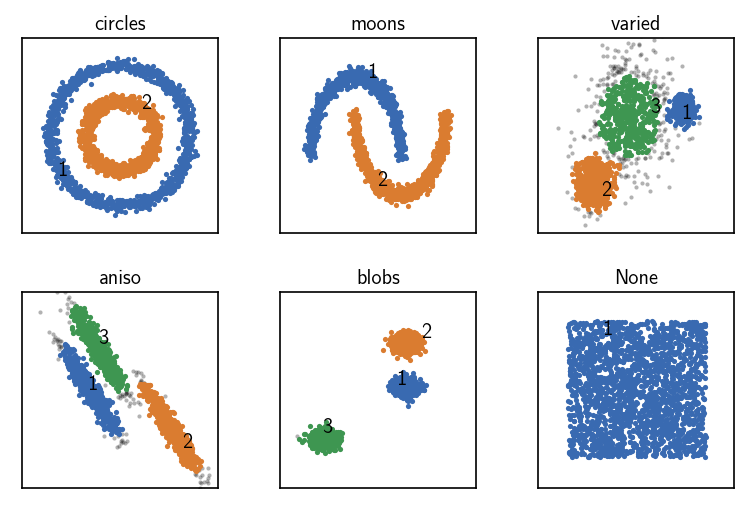

In [11]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    
    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)
    
    clustering = cluster.prepare_clustering(data)  
    
    # Pre-compute neighbourhoods
    tree = KDTree(data)
    neighbourhoods = tree.query_radius(
        data, r=params["radius_cutoff"], return_distance=False
        )
    clustering_neighbourhoods = cluster.prepare_clustering(
        neighbourhoods,
        preparation_hook=cluster.prepare_neighbourhoods,
        **cluster.registered_recipes["from_neighbourhoods_lookup"]
    )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods.fit(**params)
    clustering._labels = clustering_neighbourhoods._labels
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

## Common-nearest-neighbours clustering with pre-computed sorted neighbourhoods

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.002
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.003
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

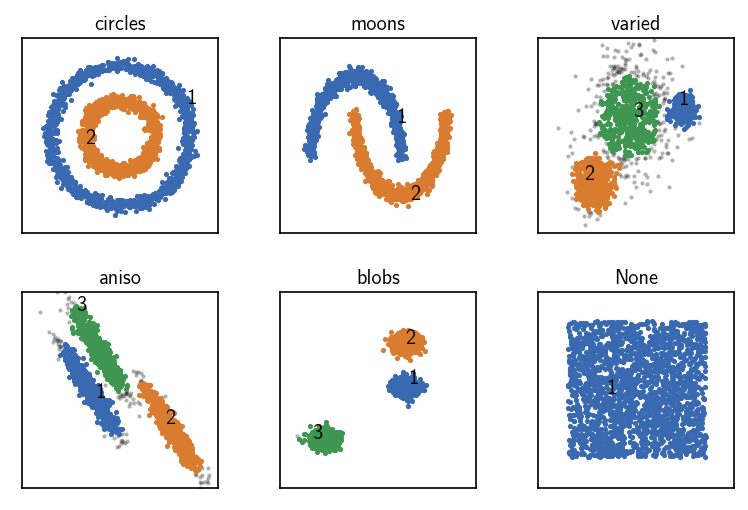

In [12]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    
    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)
    
    clustering = cluster.prepare_clustering(data)  
    
    # Pre-compute neighbourhoods
    tree = KDTree(data)
    neighbourhoods = tree.query_radius(
        data, r=params["radius_cutoff"], return_distance=False
        )

    for n in neighbourhoods:
        n.sort()

    clustering_neighbourhoods = cluster.prepare_clustering(
        neighbourhoods,
        preparation_hook=cluster.prepare_neighbourhoods,
        **cluster.registered_recipes["from_neighbourhoods_lookup"]
    )
    
    clustering_neighbourhoods._similarity_checker = _types.SimilarityCheckerExtScreensorted()
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods.fit(**params)
    clustering._labels = clustering_neighbourhoods._labels
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )